In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.linear_model import LinearRegression

from IPython.display import clear_output

from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity

In [2]:
rws = pd.read_csv('./movies_data/requests_with_suggestions.csv')

In [3]:
#Create a dataframe that will store documents, each document being the text for which a title was suggested

movie_col = []
text_col = []

titles_col = rws['title'].astype(str)
selftext_col = rws['selftext'].astype(str)

for i in rws.index.values:
    sugg_list = rws['suggestions'][i].split('%')
    text = titles_col[i] + ' ' + selftext_col[i]
    
    for sugg in sugg_list:
        movie_col.append(sugg)
        text_col.append(text)

sugg_text_df = pd.DataFrame([movie_col, text_col]).T
sugg_text_df = sugg_text_df.rename(columns = {0:'title', 1:'text'})
sugg_text_df = sugg_text_df.set_index('title')

In [4]:
# Create a dictionary that stores values of movie titles with keys of imdb title ids

movies = pd.read_csv('./movies_data/movies.csv')#.sort_values(by = 'year')

movies = movies[['id', 'primary_title', 'year']]

movies = movies[movies['id'].isin(sugg_text_df.index)] #https://stackoverflow.com/a/12098586

movies['year'] = movies['year'].astype(int)

movies = movies.sort_values(by = 'year')

title_dict = movies[['id', 'primary_title']].set_index('id').to_dict()['primary_title']

# Feature Optimization
----

The plan to evaluate the reccomendations is to compare test data to actual suggestions by the metric Recall
Recall only evaluates True Positives (movies suggested by both machine and humans) and False Negatives (movies suggested by humans but not by the machine)
This is ideal, becuase False Positives are not a big deal (and could, in fact, yield interesting results), and True Negatives make up the vast majority of the data.

Recall = TP / (TP + FN)

In a comparison of 20 recommendations, if the system predicts 5 of those titles, Recall = 5 / (5+ 15) = 0.25

To find a baseline for evaluation, the set of most recommended movies will be compared to the recommendations across all request documents. A "request document" is defined as the title + text of the recommendation, associated with a multilabel classification matrix of movie titles. This may be restricted to documents with reasonable number of suggestions (tenatively, 10 - 30), becuase as some requests saw nearly 1000 unique suggestions, the overlap between machine and human recommendations would become very large regardless of performance. Another approach would be to use comment scores to limit the suggestions to the top 20. The number 20 is chosen because that is approximately the average number of recommendations a request recieves.

To optimize features, recall will be measured, not with machine suggestions, but between the suggestions for each document and that document's most similar document in the corpus.


In [5]:
def vectorize_text(df, vectorizer, fit = True):
    #df should have 'id', 'title', and 'selftext' columns
    #function returns a dataframe with vectorized features, and the sparse matrix of features
    #the passed vectorizer is fit and can now transform other text, assuming it was initizialized outside of the function call
    
    doc_text_df = pd.DataFrame(zip(df['id'], df['title'] + df['selftext']), index = df['id'], columns = {0, 'documents'}).drop(columns = 0)

    if fit:
        X_features = vectorizer.fit_transform(doc_text_df['documents'])
    else:
        X_features = vectorizer.transform(doc_text_df['documents'])

    doc_vectors_df = pd.DataFrame(X_features.toarray(), columns = vectorizer.get_feature_names(), index = doc_text_df.index)
    
    return doc_vectors_df, X_features

In [6]:
# one-hot encodes a list of suggestions

def transform_sugg(sugg, encoder):
    return encoder.transform(np.array(sugg).reshape(-1,1))

In [7]:
# returns a dictionary that maps each document to their most similar document(s) and their similarity score(s)
#   as a list of tuples like: (title_id, cosine_distance)

def get_similarity_dict(dist_df, size = 1):
    sim_dict = {tt_id : [] for tt_id in dist_df}
    
    for item in dist_df:
        try:
            most_similar = dist_df[item].sort_values()[1 : 1 + size]
        except:
            print(f"Problem with: {item}")
        for i in range(len(most_similar)):
            sim_dict[item].append((most_similar.index.values[i], most_similar.values[i]))
        
    return sim_dict

In [8]:
#Get a recall score for two sets of laebels + scores

def compare_labels(labels1, scores1, labels2, scores2, encoder, limits = [10, 20]):
    
    labels1_df = pd.DataFrame(zip(labels1, scores1), columns = ['label', 'score']).sort_values(by = 'score', ascending = False)
    labels2_df = pd.DataFrame(zip(labels2, scores2), columns = ['label', 'score']).sort_values(by = 'score', ascending = False)
    
    #assign small and large on the assumption that 1 is large and 2 is small, check this assumption only if they aren't equal size
    large = labels1_df
    small = labels2_df
    
    # check if we need to select a limited portion of the passed labels before processing
    if len(labels1) != len(labels2) or len(labels1) not in range(limits[0], limits[1]+1):
        
        if len(labels1) < len(labels2):
            large = labels2_df
            small = labels1_df

        try:
            cutoff = large['score'][min(len(small), limits[1])]
        except:
            print(len(small))
        
        pared_large = large[large['score'] > cutoff]
        
        size = min(len(small), limits[1])
        
        difference = size - len(pared_large)
        
        while difference > 0:
            to_sample = difference
            
            if difference > len(large[large['score'] == cutoff]):
                to_sample = len(large[large['score'] == cutoff])
                
            pared_large = pared_large.append(large[large['score'] == cutoff].sample(to_sample))
            
            difference = size - len(pared_large)
            
            cutoff -= 1
            
            if cutoff < -1:
                break
        
        if(len(small)) > limits[1]:

            cutoff = small['score'][limits[1]-1]
            pared_small = small[small['score'] > cutoff]
            difference = limits[1] - len(pared_small)
        
            while difference > 0:
                to_sample = difference
            
                if difference > len(small[small['score'] == cutoff]):
                    to_sample = len(small[small['score'] == cutoff])

                pared_small = pared_small.append(small[small['score'] == cutoff].sample(to_sample))

                difference = limits[1] - len(pared_small)
                
                cutoff -= 1
                
                if cutoff < -1:
                    break
            
            small = pared_small
                
        large = pared_large
    
    # this is recall: cosine_similarity sum = True Positives, len(small) = all positives
    
    return cosine_similarity(transform_sugg(large['label'], encoder=encoder),
                        transform_sugg(small['label'], encoder=encoder)).sum() / len(small)

In [9]:
def get_recall_and_distance(df, similarity_dict, encoder, limits = [10,20], verbose = True, num_matches = 1):
# This function needs a dataframe and a similarity dictionary made with that dataframe
    count = 0

    np.random.seed(1701)

    recall_scores = []
    cos_distances = []

    for tt_id in df['id']:

        for i in range(num_matches):
            best_match = similarity_dict[tt_id][i][0]

            labels1 = df[df['id'] == tt_id]['sugg_split'].values[0]
            scores1 = df[df['id'] == tt_id]['scores'].values[0]

            labels2 = df[df['id'] == best_match]['sugg_split'].values[0]
            scores2 = df[df['id'] == best_match]['scores'].values[0]

            recall_scores.append(compare_labels(labels1, scores1, labels2, scores2, encoder = encoder, limits = limits))
            cos_distances.append(similarity_dict[tt_id][i][1])

        clear_output(wait = True)

        count += 1
        if count % 100 == 0:
            if verbose:
                print(f'{count} / {df.shape[0]}')
    
    if verbose:
        print(np.mean(recall_scores))
    
    return recall_scores, cos_distances

In [10]:
class Features_Evaluator:
    
    def __init__(self, df, vec, enc):
        self.df = df
        self.vectorizer = vec
        self.encoder = enc
        self.lr_fit = False
        
    def fit_vectorizer(self):
        doc_text_df = pd.DataFrame(zip(df['id'], df['title'] + df['selftext']), index = df['id'], columns = {0, 'documents'}).drop(columns = 0)
        self.vectorizer.fit(doc_text_df)
    
    def vectorize_text(self, fit = False):
        
        df = self.df
        vec = self.vectorizer
        
        doc_text_df = pd.DataFrame(zip(df['id'], df['title'] + df['selftext']), index = df['id'], columns = {0, 'documents'}).drop(columns = 0)

        if fit:
            X_features = vec.fit_transform(doc_text_df['documents'])
        else:
            try: 
                X_features = vec.transform(doc_text_df['documents'])
            except:
                print("Vectorizer is not fit. Use fit = True or call fit_vectorizer().")
                return

        doc_vectors_df = pd.DataFrame(X_features.toarray(), columns = vec.get_feature_names(), index = doc_text_df.index)
        
        cd_matrix = cosine_distances(X_features)

        doc_distance_df = pd.DataFrame(index = doc_vectors_df.index, columns = doc_vectors_df.index, data = cd_matrix)
        
        self.doc_vectors_df = doc_vectors_df
        self.doc_distance_df = doc_distance_df
        self.X_features = X_features
        
    def transform_sugg(self, sugg):
        return self.encoder.transform(np.array(sugg).reshape(-1,1))
    
    def make_similarity_dict(self, size = 1):
        dist_df = self.doc_distance_df
        
        sim_dict = {tt_id : [] for tt_id in dist_df}
        
        for item in dist_df:
            try:
                most_similar = dist_df[item].sort_values()[1 : 1 + size]
            except:
                print(f"Problem with: {item}")
            for i in range(len(most_similar)):
                sim_dict[item].append((most_similar.index.values[i], most_similar.values[i]))
        
        self.similarity_dict = sim_dict
        
    def get_similarity_dict(self):
        return self.similarity_dict
    
    def compare_labels(self, labels1, scores1, labels2, scores2, limits = [10, 20]):
    
        labels1_df = pd.DataFrame(zip(labels1, scores1), columns = ['label', 'score']).sort_values(by = 'score', ascending = False)
        labels2_df = pd.DataFrame(zip(labels2, scores2), columns = ['label', 'score']).sort_values(by = 'score', ascending = False)

        #assign small and large on the assumption that 1 is large and 2 is small, check this assumption only if they aren't equal size
        large = labels1_df
        small = labels2_df

        # check if we need to select a limited portion of the passed labels before processing
        if len(labels1) != len(labels2) or len(labels1) not in range(limits[0], limits[1]+1):

            if len(labels1) < len(labels2):
                large = labels2_df
                small = labels1_df

            try:
                cutoff = large['score'][min(len(small), limits[1])]
            except:
                print(len(small))

            pared_large = large[large['score'] > cutoff]

            size = min(len(small), limits[1])

            difference = size - len(pared_large)

            while difference > 0:
                to_sample = difference

                if difference > len(large[large['score'] == cutoff]):
                    to_sample = len(large[large['score'] == cutoff])

                pared_large = pared_large.append(large[large['score'] == cutoff].sample(to_sample))

                difference = size - len(pared_large)

                cutoff -= 1

                if cutoff < -1:
                    break

            if(len(small)) > limits[1]:

                cutoff = small['score'][limits[1]-1]
                pared_small = small[small['score'] > cutoff]
                difference = limits[1] - len(pared_small)

                while difference > 0:
                    to_sample = difference

                    if difference > len(small[small['score'] == cutoff]):
                        to_sample = len(small[small['score'] == cutoff])

                    pared_small = pared_small.append(small[small['score'] == cutoff].sample(to_sample))

                    difference = limits[1] - len(pared_small)

                    cutoff -= 1

                    if cutoff < -1:
                        break

                small = pared_small

            large = pared_large
        
        # this is recall: cosine_similarity sum = True Positives, len(small) = all positives
        
        return cosine_similarity(self.transform_sugg(large['label']),
                            self.transform_sugg(small['label'])).sum() / len(small)
    
    def get_recall_and_distance(self, limits = [10,20], verbose = True, num_matches = 1):
    # This function needs a dataframe and a similarity dictionary made with that dataframe
        count = 0
        
        df = self.df

        np.random.seed(1701)

        recall_scores = []
        cos_distances = []
        
        for tt_id in df['id']:

            for i in range(num_matches):
                best_match = self.similarity_dict[tt_id][i][0]

                labels1 = df[df['id'] == tt_id]['sugg_split'].values[0]
                scores1 = df[df['id'] == tt_id]['scores'].values[0]

                labels2 = df[df['id'] == best_match]['sugg_split'].values[0]
                scores2 = df[df['id'] == best_match]['scores'].values[0]

                recall_scores.append(self.compare_labels(labels1, scores1, labels2, scores2, limits = limits))
                cos_distances.append(self.similarity_dict[tt_id][i][1])

            

            count += 1
            if count % 100 == 0:
                if verbose:
                    clear_output(wait = True)
                    print(f'{count} / {df.shape[0]}')

        if verbose:
            print(f'Average recall: {np.mean(recall_scores)}')
        
        self.avg_recall = np.mean(recall_scores)
        self.avg_distance = np.mean(cos_distances)
        self.recall_scores = recall_scores
        self.cos_distances = cos_distances
        
    def linreg_recall(self):
        self.lr = LinearRegression()
        try:
            self.lr.fit(np.array(self.cos_distances).reshape(-1,1), self.recall_scores)
        except:
            print("Recall and Distances not calculated.")
            return
        self.slope = self.lr.coef_
        self.intercept = self.lr.intercept_
        self.pred1 = self.lr.predict(np.array(1).reshape(-1,1))
        self.lr_fit = True
        
        
    def print_lrstats(self):
        if self.lr_fit == False:
            self.linreg_recall()
        print(f'Slope:   {np.round(self.slope,4)}\nIntercept: {np.round(self.intercept, 4)}\nAt 1.0:   {np.round(self.pred1,4)}')
        
    def plot_recall_and_distance(self):
        if self.lr_fit == False:
            self.linreg_recall()
        
        fig = plt.figure(constrained_layout = True, figsize = (10,10))
        gs = gridspec.GridSpec(nrows = 3, ncols = 2, figure = fig)
        ax0 = fig.add_subplot(gs[0:2, 0:2])
        ax0.set_title("Recall Scores vs Cosine Distances", fontsize = 20)
        ax1 = fig.add_subplot(gs[2, 0])
        ax1.set_title("Cosine Distances", fontsize = 16)
        ax2 = fig.add_subplot(gs[2, 1])
        ax2.set_title("Recall Scores", fontsize = 16)

        x = np.linspace(0,1)
        ax0.plot(x, self.slope * x + self.intercept, color = 'gold', lw =3)
        ax0.scatter(self.cos_distances, self.recall_scores, alpha  = 0.07, color = 'seagreen')

        sns.distplot(self.cos_distances, ax = ax1, bins = 30, color = 'seagreen')
        sns.distplot(self.recall_scores, ax = ax2, bins = 30, color = 'seagreen');
        
    def process_df(self, dict_size = 1, num_matches = 1, label_limits = [10, 20], verbose = False):
        self.vectorize_text(fit = True)
        self.make_similarity_dict(size = dict_size)
        self.get_recall_and_distance(limits = label_limits, num_matches = num_matches, verbose = verbose)
        self.linreg_recall()

In [11]:
#split suggestion string into list
rws['sugg_split'] = rws['suggestions'].str.split('%')

#count the number of suggestions
rws['sugg_count'] = rws['sugg_split'].apply(len)

#split scores string into list, then convert each digit into an integer with the applied lambda function
rws['scores'] = rws['scores'].str.split(',').apply(lambda s : [int(i) for i in s])

In [12]:
all_titles = []

for sugg_list in rws['sugg_split']:
    for sugg in sugg_list:
        if sugg not in all_titles:
            all_titles.append(sugg)
            
len(all_titles)

8887

In [13]:
ohe = OneHotEncoder()

all_titles_ohe = ohe.fit_transform(np.array(all_titles).reshape(-1,1))

rws['sugg_ohe'] = rws['sugg_split'].apply(transform_sugg, encoder = ohe)

rws = rws.fillna('')

In [14]:
tf = TfidfVectorizer(max_features=5000, ngram_range=(1,3), stop_words='english')

doc_vectors_df, X = vectorize_text(rws, tf)

My ideal comparison size (for now) is in the range between 10 and 20. This provides a good number of suggestions without increasing the number so much that the comparison is meaningless. (For example, requests with 500 suggestions would have extremely high overlap, and likely have much in common with the list of 500 most suggested movies) Requests with > 20 suggestions will be pared down based on score.
This brings up a new problem: If a request has 30 suggestions, and 15 of them have score "1", and I am trying to compare to a 20-suggestion request, I will need to either:
- **A**) Limit the comparison to slices that *can* be compared accurately between 2 documents, or,
- **B**) Randomly sample the remaining suggestions to fill out the last 5 suggestions.

**A** is problematic because it will often not be possible to find any score cut-off that allows a direct comparison of top *x* suggestions between two requests. **B** is necessary because, although it is likely that suggestions are not ordered in any meaningful way, it is good to be certain that I am not optimizing for an unintentionally skewed distribution. The best solution could be to combine these: find the score cutoffs that allows the direct comparison which discards the least amount of information in my target range.

In [15]:
rws10 = rws[rws['sugg_count'] >= 10]



# Search through tfidf features on TRAINING DATA ONLY

In [19]:
tfidf_features = pd.DataFrame(columns = ['ngrams', 'max_features', 'max_df', 'min_df', 'avg_recall', 'avg_distance', 'intercept', 'pred1'])
tfidf_features = pd.read_csv('movies_data/tfidf_gridsearch_results.csv')
print(len(tfidf_features))

108


In [96]:
train_df, test_df = train_test_split(rws10, test_size = 0.2, random_state = 1701)

In [53]:
ngrams = [(3,3), (3,4), (3,5)]
max_features = [5000,7500,1000]
max_df = [0.01, 1.0]
min_df = [1]

iterations = len(ngrams) * len(max_features) * len(max_df) * len(min_df)
count = 0

for ng in ngrams:
    for mx_f in max_features:
        for mx_d in max_df:
            for mn_d in min_df:
                count +=1
                print(f'{count} / {iterations}')
                
                tf = TfidfVectorizer(ngram_range = ng, max_df = mx_d, min_df = mn_d, max_features=mx_f, stop_words='english')
                fe = Features_Evaluator(train_df, tf, ohe)
                fe.process_df()
                
                tfidf_features = tfidf_features.append({'max_df' : mx_d, 'max_features' : mx_f, 'min_df' : mn_d, 'ngrams' : ng,
                                       'avg_recall' : fe.avg_recall,
                                       'avg_distance' : fe.avg_distance,
                                       'intercept' : fe.intercept,
                                       'pred1' : fe.pred1}, ignore_index = True)

tfidf_features

1 / 18
2 / 18
3 / 18
4 / 18
5 / 18
6 / 18
7 / 18
8 / 18
9 / 18
10 / 18
11 / 18
12 / 18
13 / 18
14 / 18
15 / 18
16 / 18
17 / 18
18 / 18


,ngrams,max_features,max_df,min_df,avg_recall,avg_distance,intercept,pred1
0,"(1, 1)",1000,0.10,1.000,0.048891,0.529460,0.127078,[-0.02059501]
1,"(1, 1)",1000,0.10,0.005,0.045758,0.510569,0.121347,[-0.02670107]
2,"(1, 1)",1000,0.10,0.010,0.044712,0.420111,0.124190,[-0.06499373]
3,"(1, 1)",1000,0.30,1.000,0.049713,0.545726,0.134669,[-0.02100554]
4,"(1, 1)",1000,0.30,0.005,0.045647,0.528849,0.121042,[-0.02152322]
...,...,...,...,...,...,...,...,...
157,"(3, 5)",5000,1.00,1.000,0.058938,0.589661,0.182143,[-0.02679943960312023]
158,"(3, 5)",7500,0.01,1.000,0.058201,0.597429,0.179029,[-0.023218059081327513]
159,"(3, 5)",7500,1.00,1.000,0.058266,0.595541,0.178405,[-0.02332635952131565]
160,"(3, 5)",1000,0.01,1.000,0.086424,0.574475,0.221482,[-0.01361632891218495]


In [54]:
tfidf_features.to_csv('./movies_data/tfidf_gridsearch_results.csv', index = False)

In [64]:
tfidf_features[144:].groupby(by = 'min_df').mean()

,max_df,avg_recall,avg_distance,intercept
min_df,,,,
1,0.534615,0.058725,0.677225,0.167461


In [23]:
tfidf_features[144:].groupby(by = 'max_df').mean()

,max_features,min_df,avg_recall,avg_distance,intercept
max_df,,,,,
0.01,15000,1.0,0.049159,0.675763,0.160410
0.05,15000,1.0,0.048638,0.673206,0.157707
0.70,15000,1.0,0.048954,0.671413,0.161324
1.00,15000,1.0,0.048954,0.671413,0.161324


In [24]:
tfidf_features[144:].groupby(by = 'ngrams').mean()

,max_features,max_df,min_df,avg_recall,avg_distance,intercept
ngrams,,,,,,
"(2, 2)",15000,0.44,1.0,0.047195,0.700193,0.151928
"(2, 3)",15000,0.44,1.0,0.046733,0.670561,0.147861
"(3, 3)",15000,0.44,1.0,0.052850,0.648093,0.180786


In [25]:
tfidf_features[144:].groupby(by = 'max_features').mean()

,max_df,min_df,avg_recall,avg_distance,intercept
max_features,,,,,
10000,0.44,1.0,0.050546,0.652603,0.163866
15000,0.44,1.0,0.049259,0.675127,0.160983
20000,0.44,1.0,0.046973,0.691117,0.155725


In [27]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [44]:
model = ols(formula = "avg_recall ~ C(max_features)", data = tfidf_features[:81]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_recall   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     3.248
Date:                Sat, 03 Oct 2020   Prob (F-statistic):             0.0442
Time:                        12:00:08   Log-Likelihood:                 280.37
No. Observations:                  81   AIC:                            -554.7
Df Residuals:                      78   BIC:                            -547.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0424      0.001     28.436      0.000       0.039       0.045
C(max_features)[T.5000]     0.0044      0.002      2.097      0.039       0.000       0.009
C(max_features)[T.8000]     0.0048      0.002      2.303      0.024       0.001       0.009
==============================================================================
Omnibus:                        9.898   Durbin-Watson:                   2.733
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                5.569
Skew:                           0.459   Prob(JB):                       0.0618
Kurtosis:                       2.101   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(max_features),2.0,0.000389,0.000195,3.247573,0.044183
Residual,78.0,0.004672,0.000060,NaN,NaN


In [60]:
tf = TfidfVectorizer(max_features=1000, max_df = 0.01, ngram_range = (3,5), stop_words='english')
fe = Features_Evaluator(train_df, tf, ohe)

In [61]:
fe.process_df(verbose = True)

3600 / 3654
Average recall: 0.08642371080635866


In [62]:
fe.avg_recall

0.08642371080635866

In [63]:
fe.print_lrstats()

Slope:   [-0.2351]
Intercept: 0.2215
At 1.0:   [-0.0136]


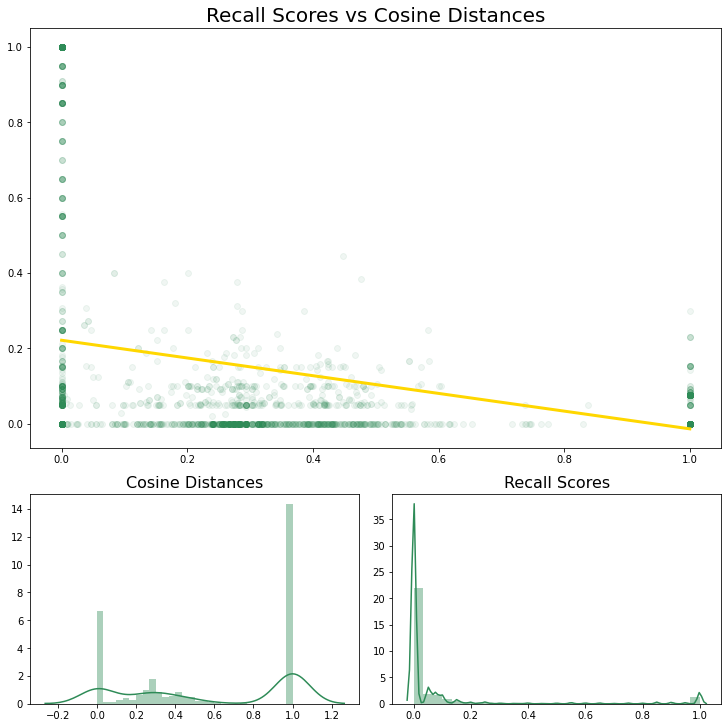

In [64]:
fe.plot_recall_and_distance()

---

In [78]:
X = fe.vectorizer.transform(sugg_text_df['text'])

In [82]:
titles_and_features = pd.DataFrame(X.toarray(), columns = fe.vectorizer.get_feature_names(), index = sugg_text_df.index)

In [83]:
titles_and_features

,10 cloverfield lane,10 favorite movies,10 things hate,12 angry men,2001 space odyssey,21 22 jump,21 22 jump street,21 jump street,22 jump street,28 days later,...,www reddit com moviesuggestions comments,www youtube com,www youtube com watch,x200b amp x200b,x200b thanks advance,x200b ve seen,year country barrier,year old virgin,yorgos lanthimos does know,youtube com watch
title,,,,,,,,,,,,,,,,,,,,,
tt1734493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt4263482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0457430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt4846232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0443706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt2543472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt3799694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt2494280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
titles_and_features = titles_and_features.groupby(by = 'title').mean()
titles_and_features

,10 cloverfield lane,10 favorite movies,10 things hate,12 angry men,2001 space odyssey,21 22 jump,21 22 jump street,21 jump street,22 jump street,28 days later,...,www reddit com moviesuggestions comments,www youtube com,www youtube com watch,x200b amp x200b,x200b thanks advance,x200b ve seen,year country barrier,year old virgin,yorgos lanthimos does know,youtube com watch
title,,,,,,,,,,,,,,,,,,,,,
tt0006864,0.0,0.0,0.0,0.000000,0.038630,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0009968,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0010323,0.0,0.0,0.0,0.015722,0.030722,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0011237,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0012364,0.0,0.0,0.0,0.062519,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9777644,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt9779516,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt9806192,0.0,0.0,0.0,0.000000,0.013654,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
test_row = test_df.sample(1)
test_row['title'].values[0] + ' ' + test_row['selftext'].values[0]

'Beautiful movies with epic music I was listening to this song and now looking for movies that have similar epic music. Something like Forrest Gump and Stardust.\n\nhttps://youtu.be/CzBYx2XyG5o?t=1m49s'

In [117]:
test_input = tf.transform([test_row['title'].values[0] + ' ' + test_row['selftext'].values[0]])

In [118]:
for i in test_row['suggestions'].values[0].split('%'):
    print(title_dict[i])

Pirates of the Caribbean: The Curse of the Black Pearl
Batman
Rogue One: A Star Wars Story
Hop
Koyaanisqatsi
Avatar
Spider-Man
The Incredibles
Highlander
Cloud Atlas
Howard the Duck
Secret Superstar
Spider-Man: Into the Spider-Verse
Unlocked
In Bruges
How to Train Your Dragon
Pacific Rim
The Machine
Sergio
Flash Gordon
Inception
Queen
Rings
Gladiator
Screwed
To Kill a Mockingbird
Interstellar
Princess Mononoke
Dragon
Rage


In [108]:
test_input = tf.transform(['I\'m looking for horror-crime movies that take place in a small town or village. A Detective or police is involved in resolving a crime which has both horror and crime elements. Doesn\'t matter if it\'s foreign, I like exploring different cultures.I prefer suspense over action and dislike cheap jump scares because they\'re mostly predictable. I\'m looking for something to keep me on the edge of my seat while sending chills down my spine.I also like monster movies but humans can be just as frightening in some cases.Good examples: The Wailing, Halloween (2018), I Saw the Devil, I See You'])

In [119]:
#test_input = tf.transform(["space"])

test_input_df = pd.DataFrame(test_input.toarray(), columns = tf.get_feature_names()).T

key_words = test_input_df.loc[test_input_df[0] > 0].index.values

rec_dict = {title : 0 for title in titles_and_features.index.values}

for word in key_words:
    if word == 'title':
        continue
    series = titles_and_features[word].sort_values(ascending = False)[:10]
    for i in series.index:
        rec_dict[i] += series[i]

score_df = pd.DataFrame(rec_dict, index = ['score']).T

score_df = score_df.loc[score_df['score'] > 0].sort_values(by = 'score', ascending = False)

for i in score_df[:10].index:
    print(title_dict[i])

The Tuxedo
Frontera
Jessabelle
Into the Grizzly Maze
Indiana Jones and the Kingdom of the Crystal Skull
Pretty Persuasion
Sand Castle
Twin Dragons
The World According to Garp
How the West Was Won


In [120]:
score_df

,score
tt0290095,1.000000
tt2510028,1.000000
tt2300975,1.000000
tt1694021,1.000000
tt0367882,0.500000
tt0381505,0.500000
tt2582576,0.500000
tt0105399,0.500000
tt0084917,0.423554
tt0056085,0.423554


In [121]:
test_input_df = pd.DataFrame(test_input.toarray(), columns = tf.get_feature_names())

In [122]:
X_df = titles_and_features.T[score_df.index].T
X_df

,10 cloverfield lane,10 favorite movies,10 things hate,12 angry men,2001 space odyssey,21 22 jump,21 22 jump street,21 jump street,22 jump street,28 days later,...,www reddit com moviesuggestions comments,www youtube com,www youtube com watch,x200b amp x200b,x200b thanks advance,x200b ve seen,year country barrier,year old virgin,yorgos lanthimos does know,youtube com watch
title,,,,,,,,,,,,,,,,,,,,,
tt0290095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt2510028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt2300975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt1694021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0367882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0381505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt2582576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0105399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0084917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
z = zip(X_df.index, cosine_similarity(X = X_df, Y = test_input_df))

In [124]:
ranking_dict = {}

for x, y in z:
    ranking_dict[title_dict[x]] =y

In [125]:
pd.DataFrame(ranking_dict).T.rename(columns = {0 : 'score'}).sort_values(by = 'score', ascending = False)[:20]

,score
How the West Was Won,0.740529
Little Big Man,0.689899
The World According to Garp,0.650709
The Tuxedo,0.593836
Jessabelle,0.593836
Into the Grizzly Maze,0.593836
Indiana Jones and the Kingdom of the Crystal Skull,0.593836
Pretty Persuasion,0.593836
Frontera,0.593836
Nowhere Boy,0.568928


In [116]:
Pirates of the Caribbean: The Curse of the Black Pearl
Batman
Rogue One: A Star Wars Story
Hop
Koyaanisqatsi
Avatar
Spider-Man
The Incredibles
Highlander
Cloud Atlas
Howard the Duck
Secret Superstar
Spider-Man: Into the Spider-Verse
Unlocked
In Bruges
How to Train Your Dragon
Pacific Rim
The Machine
Sergio
Flash Gordon
Inception
Queen
Rings
Gladiator
Screwed
To Kill a Mockingbird
Interstellar
Princess Mononoke
Dragon
Rage

SyntaxError: invalid syntax (<ipython-input-116-44974208dbfb>, line 1)